## Other Computer Vision Problems

### Multi-Label Classification

#### The Data

In [1]:
from fastai.vision.all import *

In [2]:
# download and untar some images
path = untar_data(URLs.PASCAL_2007)

In [3]:
# this time we have a file with the labels
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


#### Constructing a DataBlock

In [4]:
datablock = DataBlock()

In [5]:
datasets = datablock.datasets(df)

In [6]:
len(datasets.train), len(datasets.valid)

(4009, 1002)

In [7]:
# inspect first data item
x, y = datasets[0]
x, y

(fname       000005.jpg
 labels           chair
 is_valid          True
 Name: 0, dtype: object,
 fname       000005.jpg
 labels           chair
 is_valid          True
 Name: 0, dtype: object)

In [8]:
# constructing a data block with dependent and independent variables
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

datablock = DataBlock(get_x=get_x, get_y=get_y)
datasets = datablock.datasets(df)
datasets.train[0]

(Path('/storage/data/pascal_2007/train/008220.jpg'), ['train', 'person'])

In [9]:
# for converting the paths to images fastai has some help
datablock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     get_x=get_x, get_y=get_y)
datasets = datablock.datasets(df)
datasets.train[0]

(PILImage mode=RGB size=500x368,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0.]))

In [10]:
# see what the underlying vocab is
idxs = torch.where(datasets.train[0][1]==1.)[0]
datasets.train.vocab[idxs]

(#2) ['motorbike','person']

In [11]:
datasets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0.])

In [12]:
# because the validation samples are marked we use these
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [13]:
# now we add our same resizing to ensure all the images are the same size
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x, get_y=get_y,
                  item_tfms=RandomResizedCrop(128, min_scale=.35))
dls = dblock.dataloaders(df)

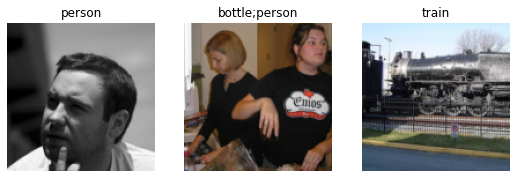

In [14]:
# inspect a batch
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [15]:
# instantiate a learner
learn = cnn_learner(dls, resnet18)

In [17]:
x, y = to_cpu(dls.train.one_batch())
activations = learn.model(x)
activations.shape

torch.Size([64, 20])

In [18]:
activations[0]

tensor([-0.2290,  0.6980, -0.5887,  4.9578,  4.9472,  2.3091, -0.7387,  0.4312,
        -3.7038,  1.6551,  1.6522, -2.3892, -4.7770,  2.5385, -1.8113, -1.9367,
         0.2219,  5.1945,  1.8042,  2.0094], grad_fn=<SelectBackward>)

In [19]:
# to use our mnist style loss we need to scale them between 0 and 1
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [20]:
# test our function
binary_cross_entropy(activations, y)

tensor(1.0853, grad_fn=<NegBackward>)

In [21]:
# and compare it to the pytorch one
nn.BCEWithLogitsLoss()(activations, y), \
    F.binary_cross_entropy_with_logits(activations, y)

(tensor(1.0853, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 tensor(1.0853, grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [22]:
# we also need a new metric for accuracy will not work
accuracy_multi??

### Metric Cutt-Off

In [23]:
# now we need to configure our metric limit
accuracy_multi_02 = partial(accuracy_multi, thresh=.2)

In [24]:
# and test our learner
learn = cnn_learner(dls, resnet50, metrics=accuracy_multi_02)
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947006,0.683365,0.241076,00:12
1,0.828582,0.560960,0.284542,00:08
2,0.604793,0.203054,0.822629,00:08
3,0.362099,0.126664,0.937689,00:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.137907,0.120754,0.939821,00:10
1,0.118275,0.108733,0.951434,00:10
2,0.099242,0.103212,0.951474,00:10


In [25]:
# now we can also change our metric and evaluate again
learn.metrics = partial(accuracy_multi, thresh=.1)
learn.validate()

(#2) [0.10321152210235596,0.9302590489387512]

In [26]:
# this result is clearly wrong so we try a bunch of
preds, targs = learn.get_preds()

In [32]:
len(dls.valid.dataset), len(preds)

(2510, 2510)

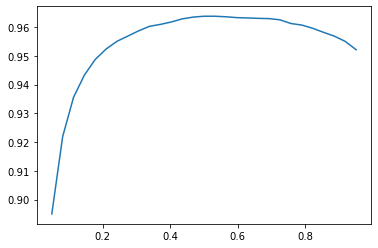

In [33]:
xs = torch.linspace(.05, .95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);